<a href="https://colab.research.google.com/github/nbessa/CIND820/blob/main/CIND820_Big_Data_Analytics_Project_Nadji_Bessa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing libraries <a class="anchor" id="first-bullet"></a>

In [ ]:
!pip install tqdm
import pandas as pd
import numpy as np
from datetime import date
import urllib.request
import glob
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import confusion_matrix

## Defining useful methods/functions

In [ ]:
def stationIDs_from_county(countyNameArg,countyStationDictArg):
  stationIDList = []
  valuesArray = list(countyStationDictArg[countyNameArg])
  maxloopIndex = len(valuesArray)
  for loopIndex in range(0,maxloopIndex):
    (stationID,climateID) = valuesArray[loopIndex]
    stationIDList.append(stationID)
  return stationIDList

def climateIDs_from_county(countyNameArg,countyStationDictArg):
  climateIDList = []
  valuesArray = list(countyStationDictArg[countyNameArg])
  maxloopIndex = len(valuesArray)
  for loopIndex in range(0,maxloopIndex):
    (stationID,climateID) = valuesArray[loopIndex]
    climateIDList.append(climateID)
  return climateIDList

def county_climateID(climateIDArg,countyStationDictArg):
  for key in list(countyStationDictArg.keys()):
    valuesArray = countyStationDictArg[key]
    maxloopIndex = len(valuesArray)
    for loopIndex in range(0,maxloopIndex):
      (stationID,climateID) = valuesArray[loopIndex]
      if climateIDArg == str(climateID):
        return key

# Building some functions to identy counties based on Environment Canada (Weather) Station ID or Climate ID
def county_from_ClimateID(climateIDArg, countyStationDictArg):
  countyList = list(countyStationDictArg.keys())
  for county in countyList:
    countyIDValues = countyStationDictArg[county]
    maxLoopIndex = len(countyIDValues)
    for loopIndex in range(maxLoopIndex):
      (stationID,climateID) = countyIDValues[loopIndex]
      if climateIDArg == climateID:
        return county

def county_from_StationID(stationIDArg,countyStationDictArg):
  countyList = list(countyStationDictArg.keys())
  for county in countyList:
    countyIDValues = countyStationDictArg[county]
    maxLoopIndex = len(countyIDValues)
    for loopIndex in range(maxLoopIndex):
      (stationID,climateID) = countyIDValues[loopIndex]
      if stationIDArg == stationID:
        return county


## Wheat crop data <a class="anchor" id="two-zero"></a>

### Loading Wheat crop data from Ontario's ministry of agriculture <a class="anchor" id="two-one"></a>

In [ ]:
from tqdm import tqdm
rawWheatCropDataFrame = pd.DataFrame()
for year in tqdm(range(2004,2023)):
  sheetNameStr = str(year) + "E"
  excelFileURL = "https://github.com/nbessa/CIND820/blob/main/source_data/crop_data/ctyswheat.xlsx?raw=true"
  tmpWheatCropDataFrame = pd.read_excel(excelFileURL, sheet_name = sheetNameStr, header = None, skiprows = [0,1,2], skipfooter = 5, names = ['County', 'Acres_seeded', 'Acre_harvested', 'Yield_bushels_per_acre', 'Production_in_Kbushels', 'Production_in_Ktonnes'], na_values=['x','-','0'])
  # Get dataframe dimension
  (max_row_size, max_col_size) = tmpWheatCropDataFrame.shape
  # Set date/time object from year
  harvestDateStr = str(year)+'-'+'01'+'-'+'01'
  # Creating a date column
  dateColumn = [harvestDateStr] * max_row_size
  # Adding the date column to the dataframe
  tmpWheatCropDataFrame.insert(0,"date",dateColumn)
  # Creating a year column
  yearColumn = [year] * max_row_size
  # Addign the year column to the dataframe
  tmpWheatCropDataFrame.insert(1,"Year",yearColumn)
  # Replacing missing values with mean Yield bushels per acre...
  meanYieldBushelsPerAcre = tmpWheatCropDataFrame['Yield_bushels_per_acre'].mean()
  tmpWheatCropDataFrame['Yield_bushels_per_acre'].fillna(value=meanYieldBushelsPerAcre, inplace=True)
  rawWheatCropDataFrame=pd.concat([rawWheatCropDataFrame,tmpWheatCropDataFrame])



100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


### Preliminary crop data examination

In [ ]:
rawWheatCropDataFrame

,date,Year,County,Acres_seeded,Acre_harvested,Yield_bushels_per_acre,Production_in_Kbushels,Production_in_Ktonnes
0,2004-01-01,2004,Chatham-Kent,100.0,100.000000,54.482409,5.450000,0.148324
1,2004-01-01,2004,Elgin,800.0,800.000000,69.791837,55.830000,1.519432
2,2004-01-01,2004,Essex,200.0,200.000000,70.236941,14.050000,0.382375
3,2004-01-01,2004,Haldimand-Norfolk,200.0,200.000000,47.381041,9.480000,0.258001
4,2004-01-01,2004,Hamilton,200.0,200.000000,50.689461,10.140000,0.275963
...,...,...,...,...,...,...,...,...
49,2022-01-01,2022,Sudbury,214.943607,214.943607,75.636779,16.257642,0.442457
50,2022-01-01,2022,Thunder Bay,332.075798,332.075798,88.581084,29.415634,0.800556
51,2022-01-01,2022,Timiskaming,14314.278207,14314.278207,62.577714,895.754802,24.378260
52,2022-01-01,2022,Northern Ontario,18995.943182,18995.943182,65.802116,1249.973262,34.018432


### Crop data clean up

In [ ]:
# Crop data clean up
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
#
#  Year 2022
#  Let's keep only the column we are interested in...
cleanWheatCropDataFrame = rawWheatCropDataFrame[["date","Year","County","Yield_bushels_per_acre"]].copy()
# Some counties are erroneously labelled 'Ontario', 'Western Ontario', etc.. let's remove those entries...
cleanWheatCropDataFrame=cleanWheatCropDataFrame[~cleanWheatCropDataFrame['County']
                                                .isin(["Ontario",
                                                       "Western Ontario",
                                                       "Eastern Ontario",
                                                       "Southern Ontario",
                                                       "Central Ontario",
                                                       "Northern Ontario"])]
# Let's convert date strings into proper datetime values...
cleanWheatCropDataFrame["date"] = pd.to_datetime(cleanWheatCropDataFrame["date"])
cleanWheatCropDataFrame["Year"] = cleanWheatCropDataFrame['Year'].astype(int)


In [ ]:
cleanWheatCropDataFrame

,date,Year,County,Yield_bushels_per_acre
0,2004-01-01,2004,Chatham-Kent,54.482409
1,2004-01-01,2004,Elgin,69.791837
2,2004-01-01,2004,Essex,70.236941
3,2004-01-01,2004,Haldimand-Norfolk,47.381041
4,2004-01-01,2004,Hamilton,50.689461
...,...,...,...,...
47,2022-01-01,2022,Nipissing,83.948220
48,2022-01-01,2022,Rainy River,69.923620
49,2022-01-01,2022,Sudbury,75.636779
50,2022-01-01,2022,Thunder Bay,88.581084


### Initial Visualization of crop data

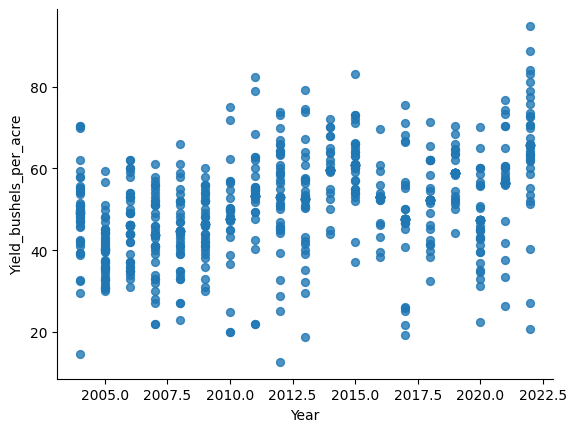

In [ ]:
from matplotlib import pyplot as plt
cleanWheatCropDataFrame.plot(kind='scatter', x='Year', y='Yield_bushels_per_acre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

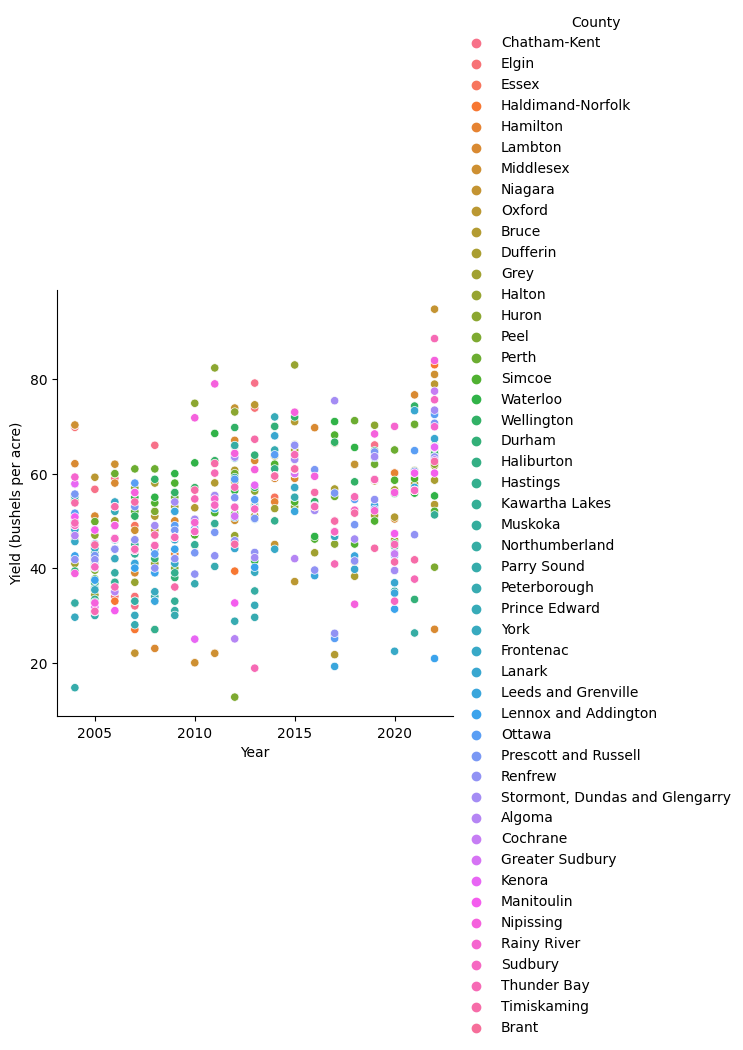

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
#cleanWheatCropDataFrame.plot(kind='scatter', x='Year', y='Yield_bushels_per_acre', s=32, alpha=.8)
#plt.gca().spines[['top', 'right',]].set_visible(False)
sns.relplot(x='Year', y='Yield_bushels_per_acre', hue='County', data=cleanWheatCropDataFrame)
plt.ylabel('Yield (bushels per acre)')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

<Axes: xlabel='Year', ylabel='Yield_bushels_per_acre'>

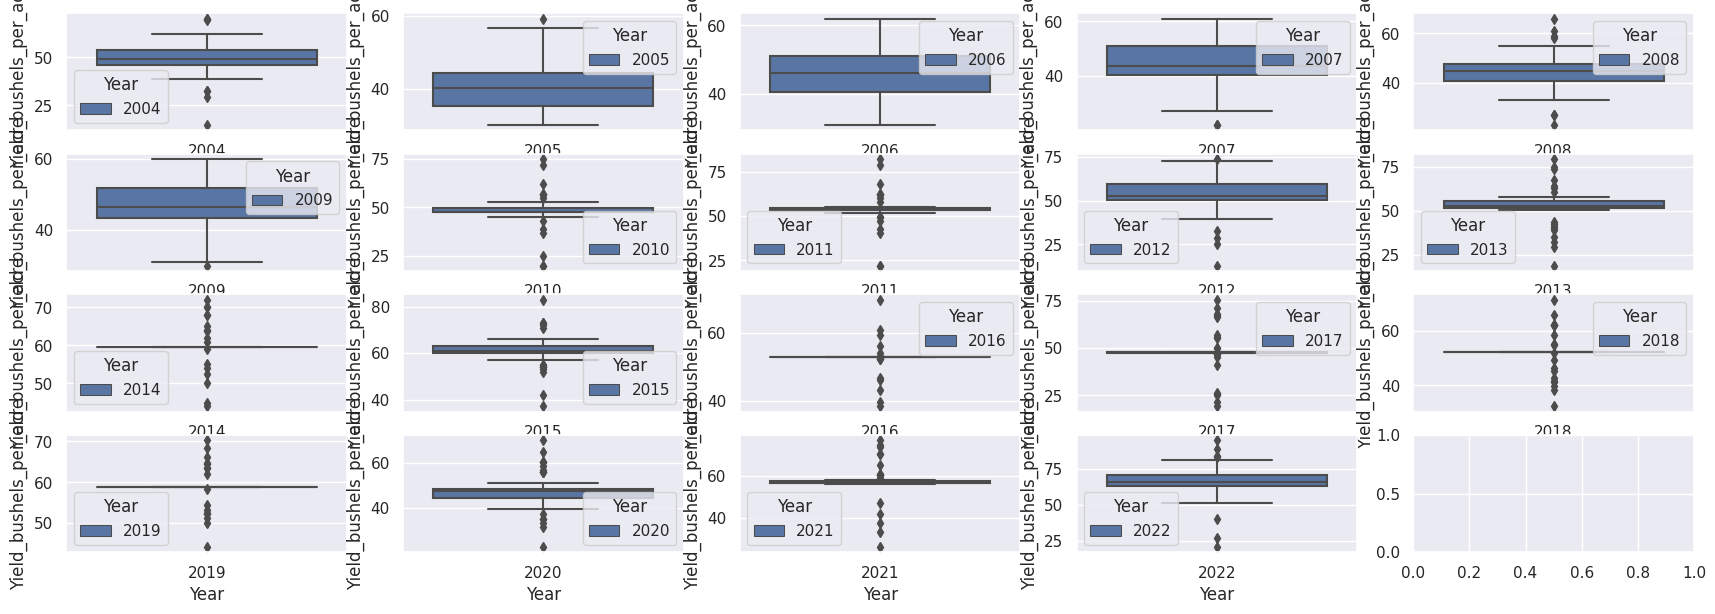

In [ ]:
studyPeriodList = list(range(2004,2023))
sns.set(rc={'figure.figsize':(21.00,7.00)})
fig, axes = plt.subplots(4,5)

sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2004)], ax=axes[0,0])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2005)], ax=axes[0,1])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2006)], ax=axes[0,2])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2007)], ax=axes[0,3])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2008)], ax=axes[0,4])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2009)], ax=axes[1,0])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2010)], ax=axes[1,1])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2011)], ax=axes[1,2])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2012)], ax=axes[1,3])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2013)], ax=axes[1,4])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2014)], ax=axes[2,0])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2015)], ax=axes[2,1])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2016)], ax=axes[2,2])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2017)], ax=axes[2,3])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2018)], ax=axes[2,4])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2019)], ax=axes[3,0])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2020)], ax=axes[3,1])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2021)], ax=axes[3,2])
sns.boxplot(x='Year', y='Yield_bushels_per_acre', hue='Year', data=cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==2022)], ax=axes[3,3])



Based on the current data distribution, it seems that for the purpose of this study only the following years should be used: 2004, 2005, 2006, 2007, 2008 and 2009.  For the other years, replacing missin values with mean values has resulted into a very narrow data distribution for the variable under study...

### Removal of crop data outliers

In [ ]:
newCleanWheatCropDataFrame = pd.DataFrame()

for lYear in studyPeriodList:
  foo = cleanWheatCropDataFrame.loc[(cleanWheatCropDataFrame['Year']==lYear)].copy()
  Q1 = foo['Yield_bushels_per_acre'].quantile(0.25)
  Q3 = foo['Yield_bushels_per_acre'].quantile(0.75)
  IQR = Q3 - Q1    #IQR is interquartile range.
  filter = (foo['Yield_bushels_per_acre'] >= Q1 - 1.5 * IQR) & (foo['Yield_bushels_per_acre'] <= Q3 + 1.5 *IQR)
  newCleanWheatCropDataFrame = pd.concat([newCleanWheatCropDataFrame,foo.loc[filter]])

cleanWheatCropDataFrame = newCleanWheatCropDataFrame.copy()

### Final visualization of crop data (without outliers)

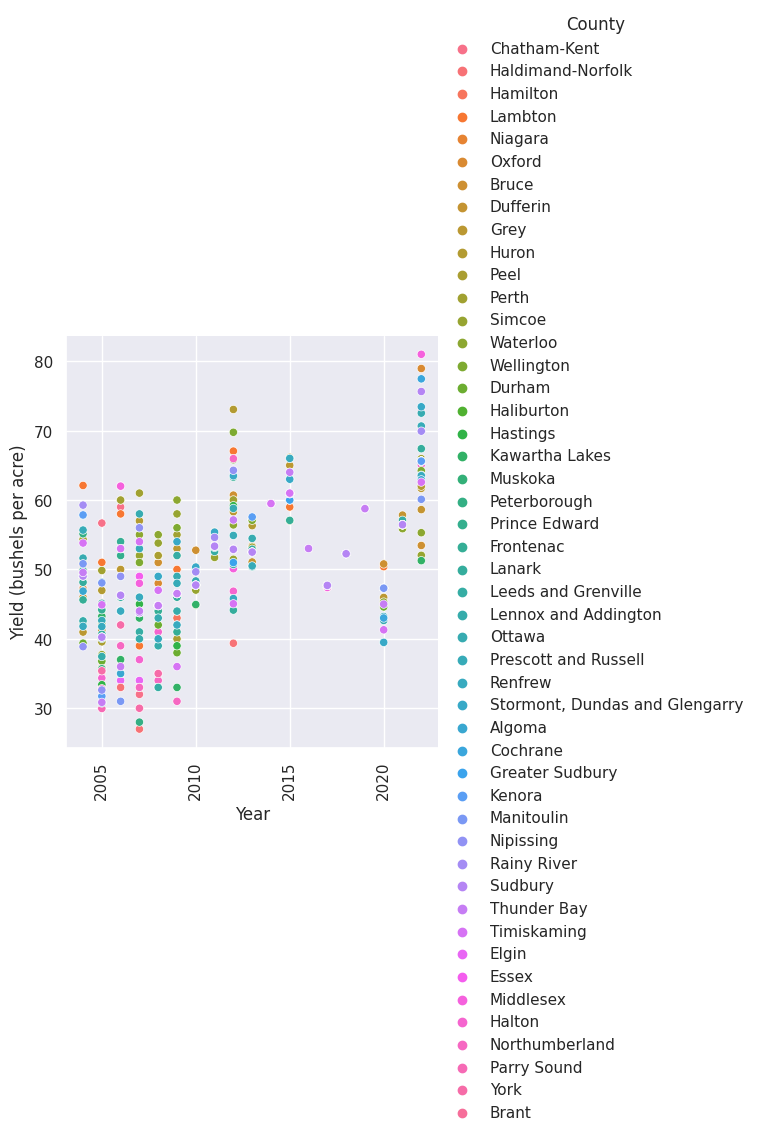

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.relplot(x='Year', y='Yield_bushels_per_acre', hue='County', data=cleanWheatCropDataFrame, kind="scatter")
plt.xticks(rotation=90)
plt.ylabel('Yield (bushels per acre)')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

### Examining crop couny-related data

In [ ]:
# What are the counties?
countyList = list(cleanWheatCropDataFrame.County.unique())
countyList.sort()
print(countyList)

['Algoma', 'Brant', 'Bruce', 'Chatham-Kent', 'Cochrane', 'Dufferin', 'Durham', 'Elgin', 'Essex', 'Frontenac', 'Greater Sudbury', 'Grey', 'Haldimand-Norfolk', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Kawartha Lakes', 'Kenora', 'Lambton', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Manitoulin', 'Middlesex', 'Muskoka', 'Niagara', 'Nipissing', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Peel', 'Perth', 'Peterborough', 'Prescott and Russell', 'Prince Edward', 'Rainy River', 'Renfrew', 'Simcoe', 'Stormont, Dundas and Glengarry', 'Sudbury', 'Thunder Bay', 'Timiskaming', 'Waterloo', 'Wellington', 'York']


In [ ]:
cleanWheatCropDataFrame

,date,Year,County,Yield_bushels_per_acre
0,2004-01-01,2004,Chatham-Kent,54.482409
3,2004-01-01,2004,Haldimand-Norfolk,47.381041
4,2004-01-01,2004,Hamilton,50.689461
5,2004-01-01,2004,Lambton,62.099574
7,2004-01-01,2004,Niagara,49.929835
...,...,...,...,...
45,2022-01-01,2022,Kenora,65.604217
46,2022-01-01,2022,Manitoulin,60.104088
48,2022-01-01,2022,Rainy River,69.923620
49,2022-01-01,2022,Sudbury,75.636779


Generating a list of counties with data for the study period of interest (i.e. 2004-2009)

In [ ]:
# which county have data from 2004 to 2009
countyWithDesirableData = cleanWheatCropDataFrame.query(("Year >= 2004 and Year <= 2009"))['County'].to_list()
countyWithDesirableData = list(set(countyWithDesirableData))
countyWithDesirableData.sort()
print(countyWithDesirableData)

['Algoma', 'Bruce', 'Chatham-Kent', 'Cochrane', 'Dufferin', 'Durham', 'Elgin', 'Essex', 'Frontenac', 'Greater Sudbury', 'Grey', 'Haldimand-Norfolk', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Kawartha Lakes', 'Kenora', 'Lambton', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Manitoulin', 'Middlesex', 'Muskoka', 'Niagara', 'Nipissing', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Peel', 'Perth', 'Peterborough', 'Prescott and Russell', 'Prince Edward', 'Rainy River', 'Renfrew', 'Simcoe', 'Stormont, Dundas and Glengarry', 'Sudbury', 'Thunder Bay', 'Timiskaming', 'Waterloo', 'Wellington', 'York']


## Weather  data

### Loading Environment Canada weather station-related data

In [ ]:
# Weather station
stationInventoryFileURL = "https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/Station_Inventory_EN.csv?raw=true"
stationInventoryDataFrame=pd.read_csv(stationInventoryFileURL, header = None,  skiprows = [0,1,2,3], names = ['Name', 'Province', 'ClimateID', 'StationID', 'WMOID', 'TCID', 'Latitude_Decimal_Degrees', 'Longitude_Decimal_Degrees', 'Latitude', 'Longitude',  'Elevation_in_m', 'FirstYear', 'LastYear', 'HLYFirstYear', 'HLYLastYear', 'DLYFirstYear', 'DLYLastYear', 'MLYFirstYear', 'MLYLastYear'])
#print(stationInventoryDataFrame.info())


In [ ]:
# Data w/
#   Province = 'ONTARIO'
#   FirstYear <= 2004  - to match crop data years...
#   LastYear >= 2022
# Show: Name, StationID, ClimateID, Province, FirstYear, LastYear
stationInventorySubset1DataFrame = stationInventoryDataFrame[['Name','StationID','ClimateID',
                                             'Latitude_Decimal_Degrees','Longitude_Decimal_Degrees',
                                            'Province','FirstYear','LastYear']]
stationInventorySubset2DataFrame = stationInventorySubset1DataFrame[
    ((stationInventorySubset1DataFrame["FirstYear"] <= 2004) & (stationInventorySubset1DataFrame["LastYear"] >= 2023 ) &
     (stationInventorySubset1DataFrame["Province"] == 'ONTARIO'))
    ].copy()
stationInventorySubset2DataFrame["Latitude_Decimal_Degrees"] =  stationInventorySubset2DataFrame["Latitude_Decimal_Degrees"].astype(float)
stationInventorySubset2DataFrame["Longitude_Decimal_Degrees"] =  stationInventorySubset2DataFrame["Longitude_Decimal_Degrees"].astype(float)


In [ ]:
stationInventorySubset2DataFrame

,Name,StationID,ClimateID,Latitude_Decimal_Degrees,Longitude_Decimal_Degrees,Province,FirstYear,LastYear
5126,EAR FALLS (AUT),27865,6012199,50.63,-93.22,ONTARIO,1999,2023
5133,LANSDOWNE HOUSE (AUT),10244,6014353,52.20,-87.94,ONTARIO,1992,2023
5137,PEAWANUCK (AUT),10197,6016295,54.98,-85.43,ONTARIO,1994,2023
5139,PICKLE LAKE (AUT),3920,6016525,51.45,-90.22,ONTARIO,1930,2023
5160,BARWICK,3932,6020559,48.63,-93.97,ONTARIO,1978,2023
...,...,...,...,...,...,...,...,...
6527,POINT PETRE (AUT),7925,6156559,43.83,-77.15,ONTARIO,1992,2023
6568,TORONTO CITY,31688,6158355,43.67,-79.40,ONTARIO,2002,2023
6654,TRENTON A,5126,6158875,44.12,-77.53,ONTARIO,1935,2023
6715,HALIBURTON 3,5170,6163171,45.03,-78.53,ONTARIO,1987,2023


### Visualization of weather station geolocation

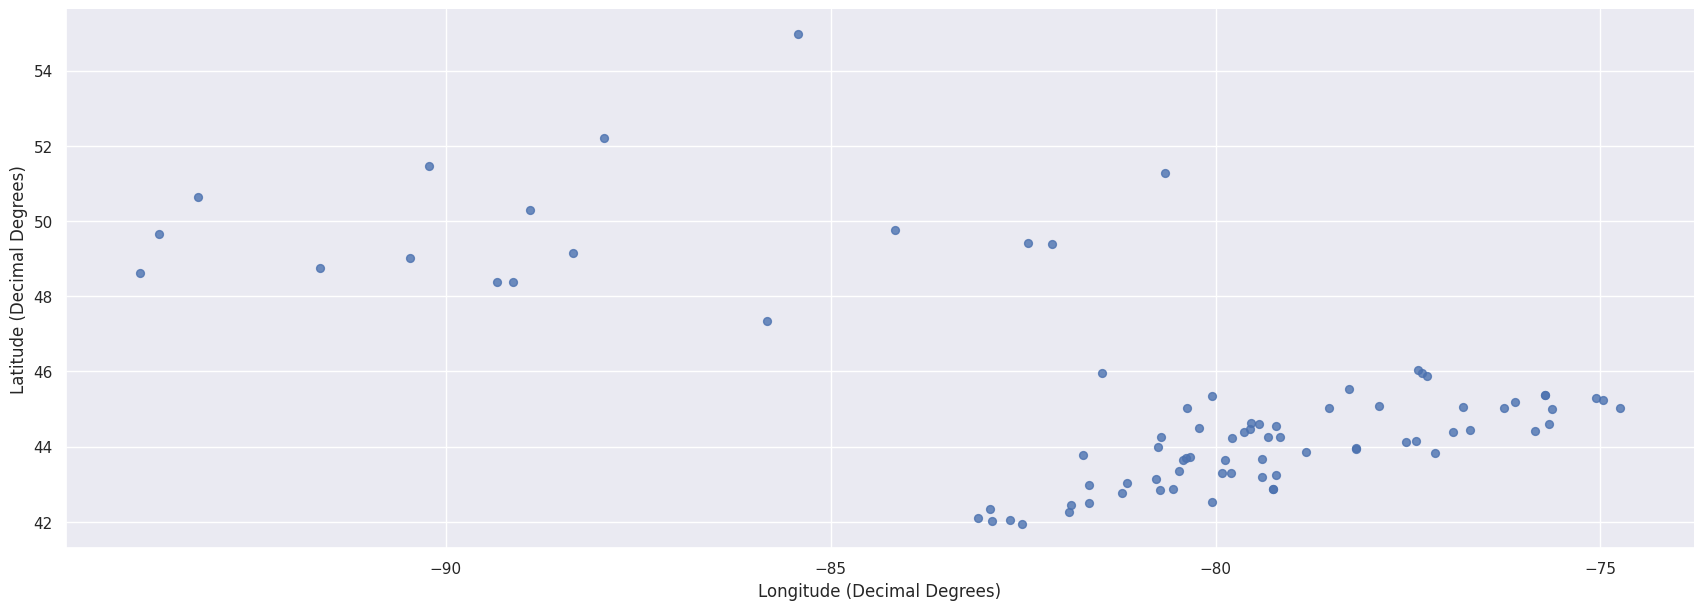

In [ ]:
from matplotlib import pyplot as plt
stationInventorySubset2DataFrame.plot(kind='scatter', x='Longitude_Decimal_Degrees', y='Latitude_Decimal_Degrees', s=32, alpha=.8)

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Longitude (Decimal Degrees)')
plt.ylabel('Latitude (Decimal Degrees)')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

Since the network of weather stations in South West regions of  Ontario are closer together. it stands to reason that the weather data they provide is more accurate representation of field condition when compaired to North West Ontario.
The region betwen (decimal) Longitude_Decimal_Degrees -82.5 and -75 as well as between (decimal) Latitude_Decimal_Degrees 42 and 46 will be used for this study

In [ ]:
stationIdOfInterestList = stationInventorySubset2DataFrame.query("Longitude_Decimal_Degrees > -82.5 & Longitude_Decimal_Degrees < -75 & Latitude_Decimal_Degrees >= 42 & Latitude_Decimal_Degrees <= 46")["StationID"].tolist()
climateIdOfInterestList = stationInventorySubset2DataFrame.query("Longitude_Decimal_Degrees > -82.5 & Longitude_Decimal_Degrees < -75 & Latitude_Decimal_Degrees >= 42 & Latitude_Decimal_Degrees <= 46")["ClimateID"].tolist()

#### Inventory of weather station data per Ontario county

In [ ]:
# Using 'Mike V.A. Burrell's map i.e. https://www.google.com/maps/d/viewer?mid=1kKPz6L-BMydiGF0UHmJYfjgBuoY&hl=en_US&ll=44.57314275920975%2C-78.63639040674295&z=9
# and the list of weather stations, the following list of counties and their weather stations was computed...
#Appleton is the last entry...
countyWeatherStationDictionary={
"Algoma": [(50092, "6057591"),(7633,"6075543")],
"Brant": [(53378, "6140942")],
"Chatham-Kent":[(52118, "6131414"),(32473,"6137154"),(9006,"613KLLM")],
"Cochrane": [(50460, "6078286"),(30435,"6073980"),(4140	,"6070QK6"), (4140,"6070QK6")],
#"Dufferin": "N/A",
"Durham": [(4996,"6155878")],
"Elgin": [(4656,"6135583"),(4689,"6137362")],
"Essex": [(4647,"6134190"),(30266,"6133362"),(27533, "613P001"),(4715,"6139520")],
"Frontenac":[(4287,"6103367")],
"Greater Sudbury": [(50840, "6068153")],
"Grey": [(43046,"6114979")],
"Haliburton": [(42967,"6080192"),(5170,"6163171")],
"Halton": [(51459,"6158731"),(7868,"6151061"),(4923,"6152695")],
"Hamilton": [(49908, "6153193"), (27529,"6153301")],
"Hastings":[(5126,"6158875"), (4859,"6150689")],
"Huron": [(7747,"6122847")],
"Kawartha Lakes": [(29906, "6166420")],
"Kenora": [(51137, "6034076"),(27865,"6012199"), (10244,"6014353"),
          (10197, "6016295"),(3920,"6016525"),(4168,"6075425"),(42123,"6075435")],
"Lambton": [(48373, "6127510")],
"Lanark": [(4255,"6101874"),(4255,"6101874"),(4268,"6102J13")],
"Leeds and Grenville":[(4236	,"6100971"),(10903,"6103024"),(27534,"6104027"), (4236,"6100971"),(10903,"6103024")],
"Lennox and Addington": [(4898,"6151309")],
#"Manitoulin": "N/A",
"Middlesex": [(27647,"6148122" ), (27647,"6148122"), (27647,"6110480")],
"Muskoka": [(48368, "6115529")],
"Niagara": [(50131, "6137286"),(4635,"6132470"),(4671,"6136606"),(9005,"613F606"), (7790,"6136699"),(31367,"6139148")],
"Norfolk": [(9026, "6134F10")],
#"Nipissing": "N/A",
"Northumberland": [(7870,"6151684"),(4905,"6151689"),(7925,"6156559")],
"Ottawa": [(49568, "6106001"),(6901,"6100285")],
"Oxford":[(27528	,"6131983"),(4835, "6149625"),(4699,"6138270"), (4699,"6138270")],
"Parry Sound": [(32128, "6116257")],
#"Peel": "N/A",
#"Perth": "N/A",
"Peterborough": [(48952, "6166415")],
#"Prescott and Russell": "N/A",
#"Prince Edward": "N/A",
"Rainy River": [(10220  ,"6020LPQ"),(3932,"6020559")],
"Renfrew": [(4243,	"6101335")],
"Simcoe": [(4432,"6111769"),(10955,"6111792"),(10911,"6114295"), (10911, "6114295"), (4480,"6115811"), (6904,"6117684"),(42183,"6117700")],
#"Stormont, Dundas and Glengarry": "N/A",
"Sudbury":[(3966, "6036904"),(30455, "6036907"),( 8997,"605DJ25"),(4121, "6065006")],
"Thunder Bay": [(10899,"6037201"),(27674,"6041110"),(4057, "6049095"), (26912,"604S001"	),
                (7582,"6041222"),(30682 ,"6048268"),(4061,"6049443"),(3987,"6040325")],
"Toronto": [(31688,"6158355")],
"Timiskaming":[(49489,"6072223"),( 27535, "6074211")],
#"Waterloo": "N/A",
"Wellington": [(41983,"6142286"),(4760, "6142400"),(4761, "6142402")],
"York": [(4525,"6119055")]
}


### Pre-weather data ingestion preparation

In [ ]:
stationIDList = []
climateIDList = []
for keyItem in list(countyWeatherStationDictionary.keys()):
  valueList = countyWeatherStationDictionary[keyItem]
  for i in range(len(valueList)):
    (stationID, ClimateID) = valueList[i]
    stationIDList.append(stationID)
    climateIDList.append(ClimateID)

stationIDList = list(set(stationIDList))
climateIDList = list(set(climateIDList))
print(list(countyWeatherStationDictionary.keys()))
print(stationIDList)
print(climateIDList)


#print("The county associated with Station ID: 48952 is ", county_from_StationID(48952))
#print("The county associated with Climate ID: 6034076 is ", county_from_ClimateID(6034076))

['Algoma', 'Brant', 'Chatham-Kent', 'Cochrane', 'Durham', 'Elgin', 'Essex', 'Frontenac', 'Greater Sudbury', 'Grey', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Kawartha Lakes', 'Kenora', 'Lambton', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Middlesex', 'Muskoka', 'Niagara', 'Norfolk', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Peterborough', 'Rainy River', 'Renfrew', 'Simcoe', 'Sudbury', 'Thunder Bay', 'Toronto', 'Timiskaming', 'Wellington', 'York']
[10244, 5126, 4121, 27674, 4635, 43046, 4647, 4140, 4656, 5170, 30266, 4671, 7747, 4168, 4689, 4699, 4715, 7790, 53378, 31367, 42123, 4236, 4243, 10899, 10903, 50840, 4760, 4761, 4255, 10911, 4268, 7868, 7870, 4287, 42183, 10955, 29906, 32473, 27865, 30435, 4835, 48368, 49908, 48373, 7925, 30455, 6901, 6904, 4859, 51459, 41983, 50460, 26912, 4898, 8997, 4905, 9005, 9006, 48952, 4923, 9026, 3920, 4432, 49489, 3932, 3966, 32128, 4480, 4996, 27528, 27529, 27533, 27534, 27535, 3987, 52118, 7582, 49568, 50

### Weather data ingestion

In [ ]:
# https://stackoverflow.com/questions/55240330/how-to-read-csv-file-from-github-using-pandas

import pandas as pd
import urllib.request
from urllib.error import HTTPError
import glob
from datetime import date
from tqdm import tqdm
# Adjusting the study period from 2004 to 2007 since it seems weather data from 2004 to 2007 seems to be unavailable
rawWeatherDataFrame = pd.DataFrame()
# Change date range to 2004 to 2022 eventually...
for climateID in tqdm(climateIDList):
  for year in range(2004,2023):
    try:
   # typical file name: 'en_climate_daily_ON_6034076_2010_P1D'
      csvFileURL = "https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_"+climateID+"_"+str(year)+"_P1D.csv?raw=true"
      tmpWeatherDataFrame = pd.read_csv(csvFileURL,
                                   parse_dates=True
                                   )
      (maxRowSizeWeather, maxColSizeWeather) = tmpWeatherDataFrame.shape
      #print("maxRowSizeWeather:",maxRowSizeWeather)
      # Adding County to original station data
      tmpCountyColumnList = [county_from_ClimateID(climateID,countyWeatherStationDictionary)] * maxRowSizeWeather
      tmpWeatherDataFrame['County'] = tmpCountyColumnList
      # Replacing missing values with mean values...
      meanMaxTemp =tmpWeatherDataFrame['Max Temp (°C)'].mean()
      tmpWeatherDataFrame['Max Temp (°C)'].fillna(value=meanMaxTemp, inplace=True)
      # Concatenating temporary dataframe into one aggregate
      # w/ ignore_index=True to ensure that autogenrated index in the resulting
      # dataframe
      rawWeatherDataFrame=pd.concat([rawWeatherDataFrame,tmpWeatherDataFrame],ignore_index=True)
    except HTTPError:
      print('The file/URL ', csvFileURL, 'was not found!',"(",climateID,")")
      continue

  0%|          | 0/92 [00:00<?, ?it/s]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6074211_2004_P1D.csv?raw=true was not found! ( 6074211 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6074211_2005_P1D.csv?raw=true was not found! ( 6074211 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6074211_2006_P1D.csv?raw=true was not found! ( 6074211 )


  1%|          | 1/92 [00:21<33:04, 21.80s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6104027_2004_P1D.csv?raw=true was not found! ( 6104027 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6104027_2005_P1D.csv?raw=true was not found! ( 6104027 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6104027_2006_P1D.csv?raw=true was not found! ( 6104027 )


  2%|▏         | 2/92 [00:46<34:49, 23.22s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6132470_2004_P1D.csv?raw=true was not found! ( 6132470 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6132470_2005_P1D.csv?raw=true was not found! ( 6132470 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6132470_2006_P1D.csv?raw=true was not found! ( 6132470 )


  3%|▎         | 3/92 [01:09<34:33, 23.30s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_604S001_2004_P1D.csv?raw=true was not found! ( 604S001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_604S001_2005_P1D.csv?raw=true was not found! ( 604S001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_604S001_2006_P1D.csv?raw=true was not found! ( 604S001 )


  4%|▍         | 4/92 [01:33<34:28, 23.50s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6065006_2004_P1D.csv?raw=true was not found! ( 6065006 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6065006_2005_P1D.csv?raw=true was not found! ( 6065006 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6065006_2006_P1D.csv?raw=true was not found! ( 6065006 )


  9%|▊         | 8/92 [03:09<34:00, 24.29s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101335_2004_P1D.csv?raw=true was not found! ( 6101335 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101335_2005_P1D.csv?raw=true was not found! ( 6101335 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101335_2006_P1D.csv?raw=true was not found! ( 6101335 )


 10%|▉         | 9/92 [03:30<32:24, 23.42s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075435_2004_P1D.csv?raw=true was not found! ( 6075435 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075435_2005_P1D.csv?raw=true was not found! ( 6075435 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075435_2006_P1D.csv?raw=true was not found! ( 6075435 )


 11%|█         | 10/92 [03:54<32:16, 23.62s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6127510_2004_P1D.csv?raw=true was not found! ( 6127510 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6127510_2005_P1D.csv?raw=true was not found! ( 6127510 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6127510_2006_P1D.csv?raw=true was not found! ( 6127510 )


 12%|█▏        | 11/92 [04:16<30:55, 22.91s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6034076_2004_P1D.csv?raw=true was not found! ( 6034076 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6034076_2005_P1D.csv?raw=true was not found! ( 6034076 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6034076_2006_P1D.csv?raw=true was not found! ( 6034076 )


 15%|█▌        | 14/92 [05:29<31:27, 24.20s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6078286_2004_P1D.csv?raw=true was not found! ( 6078286 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6078286_2005_P1D.csv?raw=true was not found! ( 6078286 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6078286_2006_P1D.csv?raw=true was not found! ( 6078286 )


 20%|█▉        | 18/92 [07:05<29:55, 24.27s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_613P001_2004_P1D.csv?raw=true was not found! ( 613P001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_613P001_2005_P1D.csv?raw=true was not found! ( 613P001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_613P001_2006_P1D.csv?raw=true was not found! ( 613P001 )


 21%|██        | 19/92 [07:26<28:18, 23.27s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6158731_2004_P1D.csv?raw=true was not found! ( 6158731 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6158731_2005_P1D.csv?raw=true was not found! ( 6158731 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6158731_2006_P1D.csv?raw=true was not found! ( 6158731 )


 24%|██▍       | 22/92 [08:34<26:45, 22.94s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6014353_2004_P1D.csv?raw=true was not found! ( 6014353 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6014353_2005_P1D.csv?raw=true was not found! ( 6014353 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6014353_2006_P1D.csv?raw=true was not found! ( 6014353 )


 25%|██▌       | 23/92 [08:56<26:09, 22.74s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6016295_2004_P1D.csv?raw=true was not found! ( 6016295 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6016295_2005_P1D.csv?raw=true was not found! ( 6016295 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6016295_2006_P1D.csv?raw=true was not found! ( 6016295 )


 27%|██▋       | 25/92 [09:44<26:17, 23.54s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049443_2004_P1D.csv?raw=true was not found! ( 6049443 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049443_2005_P1D.csv?raw=true was not found! ( 6049443 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049443_2006_P1D.csv?raw=true was not found! ( 6049443 )


 28%|██▊       | 26/92 [10:05<25:09, 22.88s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036907_2004_P1D.csv?raw=true was not found! ( 6036907 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036907_2005_P1D.csv?raw=true was not found! ( 6036907 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036907_2006_P1D.csv?raw=true was not found! ( 6036907 )


 29%|██▉       | 27/92 [10:27<24:16, 22.40s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036904_2004_P1D.csv?raw=true was not found! ( 6036904 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036904_2005_P1D.csv?raw=true was not found! ( 6036904 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6036904_2006_P1D.csv?raw=true was not found! ( 6036904 )


 33%|███▎      | 30/92 [11:38<24:14, 23.46s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075425_2004_P1D.csv?raw=true was not found! ( 6075425 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075425_2005_P1D.csv?raw=true was not found! ( 6075425 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075425_2006_P1D.csv?raw=true was not found! ( 6075425 )


 34%|███▎      | 31/92 [11:59<23:04, 22.70s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6057591_2004_P1D.csv?raw=true was not found! ( 6057591 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6057591_2005_P1D.csv?raw=true was not found! ( 6057591 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6057591_2006_P1D.csv?raw=true was not found! ( 6057591 )


 35%|███▍      | 32/92 [12:22<22:46, 22.77s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6106001_2004_P1D.csv?raw=true was not found! ( 6106001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6106001_2005_P1D.csv?raw=true was not found! ( 6106001 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6106001_2006_P1D.csv?raw=true was not found! ( 6106001 )


 39%|███▉      | 36/92 [14:01<23:07, 24.78s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020559_2004_P1D.csv?raw=true was not found! ( 6020559 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020559_2005_P1D.csv?raw=true was not found! ( 6020559 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020559_2006_P1D.csv?raw=true was not found! ( 6020559 )


 42%|████▏     | 39/92 [15:11<21:02, 23.83s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6048268_2004_P1D.csv?raw=true was not found! ( 6048268 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6048268_2005_P1D.csv?raw=true was not found! ( 6048268 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6048268_2006_P1D.csv?raw=true was not found! ( 6048268 )


 48%|████▊     | 44/92 [17:15<19:40, 24.59s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020LPQ_2004_P1D.csv?raw=true was not found! ( 6020LPQ )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020LPQ_2005_P1D.csv?raw=true was not found! ( 6020LPQ )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6020LPQ_2006_P1D.csv?raw=true was not found! ( 6020LPQ )


 49%|████▉     | 45/92 [17:39<19:00, 24.28s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041110_2004_P1D.csv?raw=true was not found! ( 6041110 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041110_2005_P1D.csv?raw=true was not found! ( 6041110 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041110_2006_P1D.csv?raw=true was not found! ( 6041110 )


 50%|█████     | 46/92 [18:04<18:50, 24.58s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041222_2004_P1D.csv?raw=true was not found! ( 6041222 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041222_2005_P1D.csv?raw=true was not found! ( 6041222 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6041222_2006_P1D.csv?raw=true was not found! ( 6041222 )


 52%|█████▏    | 48/92 [18:57<18:42, 25.52s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6070QK6_2004_P1D.csv?raw=true was not found! ( 6070QK6 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6070QK6_2005_P1D.csv?raw=true was not found! ( 6070QK6 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6070QK6_2006_P1D.csv?raw=true was not found! ( 6070QK6 )


 54%|█████▍    | 50/92 [19:47<17:52, 25.54s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2007_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2008_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2009_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2010_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2011_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2012_P1D.csv?raw=true was not found! ( 6148122 )
The file/URL  https://github.com/nbessa/

 55%|█████▌    | 51/92 [19:58<14:35, 21.34s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6148122_2022_P1D.csv?raw=true was not found! ( 6148122 )


 57%|█████▋    | 52/92 [20:24<15:04, 22.61s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6072223_2004_P1D.csv?raw=true was not found! ( 6072223 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6072223_2005_P1D.csv?raw=true was not found! ( 6072223 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6072223_2006_P1D.csv?raw=true was not found! ( 6072223 )


 59%|█████▊    | 54/92 [21:15<15:21, 24.25s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049095_2004_P1D.csv?raw=true was not found! ( 6049095 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049095_2005_P1D.csv?raw=true was not found! ( 6049095 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6049095_2006_P1D.csv?raw=true was not found! ( 6049095 )


 61%|██████    | 56/92 [22:12<15:53, 26.48s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6115529_2004_P1D.csv?raw=true was not found! ( 6115529 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6115529_2005_P1D.csv?raw=true was not found! ( 6115529 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6115529_2006_P1D.csv?raw=true was not found! ( 6115529 )


 63%|██████▎   | 58/92 [23:03<14:48, 26.12s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6040325_2004_P1D.csv?raw=true was not found! ( 6040325 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6040325_2005_P1D.csv?raw=true was not found! ( 6040325 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6040325_2006_P1D.csv?raw=true was not found! ( 6040325 )


 66%|██████▋   | 61/92 [24:17<13:13, 25.59s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6137286_2004_P1D.csv?raw=true was not found! ( 6137286 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6137286_2005_P1D.csv?raw=true was not found! ( 6137286 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6137286_2006_P1D.csv?raw=true was not found! ( 6137286 )


 67%|██████▋   | 62/92 [24:39<12:10, 24.35s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101874_2004_P1D.csv?raw=true was not found! ( 6101874 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101874_2005_P1D.csv?raw=true was not found! ( 6101874 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6101874_2006_P1D.csv?raw=true was not found! ( 6101874 )


 68%|██████▊   | 63/92 [25:01<11:24, 23.62s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6153193_2004_P1D.csv?raw=true was not found! ( 6153193 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6153193_2005_P1D.csv?raw=true was not found! ( 6153193 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6153193_2006_P1D.csv?raw=true was not found! ( 6153193 )


 74%|███████▍  | 68/92 [27:07<10:13, 25.57s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6140942_2004_P1D.csv?raw=true was not found! ( 6140942 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6140942_2005_P1D.csv?raw=true was not found! ( 6140942 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6140942_2006_P1D.csv?raw=true was not found! ( 6140942 )


 76%|███████▌  | 70/92 [27:58<09:23, 25.60s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6068153_2004_P1D.csv?raw=true was not found! ( 6068153 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6068153_2005_P1D.csv?raw=true was not found! ( 6068153 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6068153_2006_P1D.csv?raw=true was not found! ( 6068153 )


 78%|███████▊  | 72/92 [28:48<08:30, 25.50s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6012199_2004_P1D.csv?raw=true was not found! ( 6012199 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6012199_2005_P1D.csv?raw=true was not found! ( 6012199 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6012199_2006_P1D.csv?raw=true was not found! ( 6012199 )


 87%|████████▋ | 80/92 [32:20<05:20, 26.70s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166415_2004_P1D.csv?raw=true was not found! ( 6166415 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166415_2005_P1D.csv?raw=true was not found! ( 6166415 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166415_2006_P1D.csv?raw=true was not found! ( 6166415 )


 88%|████████▊ | 81/92 [32:43<04:42, 25.69s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166420_2004_P1D.csv?raw=true was not found! ( 6166420 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166420_2005_P1D.csv?raw=true was not found! ( 6166420 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6166420_2006_P1D.csv?raw=true was not found! ( 6166420 )


 90%|█████████ | 83/92 [33:33<03:49, 25.46s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075543_2004_P1D.csv?raw=true was not found! ( 6075543 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075543_2005_P1D.csv?raw=true was not found! ( 6075543 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6075543_2006_P1D.csv?raw=true was not found! ( 6075543 )


 92%|█████████▏| 85/92 [34:24<02:58, 25.56s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6073980_2004_P1D.csv?raw=true was not found! ( 6073980 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6073980_2005_P1D.csv?raw=true was not found! ( 6073980 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6073980_2006_P1D.csv?raw=true was not found! ( 6073980 )


 97%|█████████▋| 89/92 [36:07<01:17, 25.81s/it]

The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6131414_2004_P1D.csv?raw=true was not found! ( 6131414 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6131414_2005_P1D.csv?raw=true was not found! ( 6131414 )
The file/URL  https://github.com/nbessa/CIND820/blob/main/source_data/weather_data/en_climate_daily_ON_6131414_2006_P1D.csv?raw=true was not found! ( 6131414 )


100%|██████████| 92/92 [37:23<00:00, 24.39s/it]


### Weather data clean up

In [ ]:
# Only keeping max temperature - min. and mean are not always recorded...
cleanWeatherDataFrame = rawWeatherDataFrame[["Date/Time","Station Name","Climate ID","County","Year","Month","Day",
                                             "Max Temp (°C)","Total Rain (mm)"]].copy()
# Drop NaN - https://www.statology.org/pandas-dropna-specific-column/
# or replace NaN with other values - https://www.w3schools.com/python/pandas/pandas_cleaning_empty_cells.asp
cleanWeatherDataFrame.dropna(subset = [
    'Max Temp (°C)',
    'Total Rain (mm)'], inplace=True
)

In [ ]:
cleanWeatherDataFrame

,Date/Time,Station Name,Climate ID,County,Year,Month,Day,Max Temp (°C),Total Rain (mm)
0,2007-01-01,KIRKLAND LAKE CS,6074211,Timiskaming,2007,1,1,0.3,0.0
85,2007-03-27,KIRKLAND LAKE CS,6074211,Timiskaming,2007,3,27,7.2,0.0
93,2007-04-04,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,4,2.0,0.0
94,2007-04-05,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,5,-7.6,0.0
106,2007-04-17,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,17,9.0,0.0
...,...,...,...,...,...,...,...,...,...
587695,2022-12-27,FERGUS MOE,6142402,Wellington,2022,12,27,-1.0,0.0
587696,2022-12-28,FERGUS MOE,6142402,Wellington,2022,12,28,5.0,0.0
587697,2022-12-29,FERGUS MOE,6142402,Wellington,2022,12,29,8.5,0.0
587698,2022-12-30,FERGUS MOE,6142402,Wellington,2022,12,30,9.0,9.0


In [ ]:
# Converting text/string to datetime object
cleanWeatherDataFrame['Date/Time'] =pd.to_datetime(cleanWeatherDataFrame['Date/Time'], format='%Y-%m-%d' )
# Converting text/string to integer
#cleanWeatherDataFrame['Climate ID'] = cleanWeatherDataFrame['Climate ID'].astype(int)
# Drop duplicates (and modify the actual Datafram w/ inplace=True)
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
cleanWeatherDataFrame.drop_duplicates(keep='first', inplace=True)
#print("Shape of cleanWeatherDataFrame dataframe after duplicates")
#print(cleanWeatherDataFrame.shape)
cleanWeatherDataFrame = cleanWeatherDataFrame.set_index('Date/Time')
cleanWeatherDataFrame.rename(columns={ "Max Temp (°C)": "Max_temperature_c",
                                       "Total Rain (mm)": "Total_rain_mm"},inplace=True)
cleanWeatherDataFrame.dropna(inplace=True)
#print("Sample 13th entry...")
#print(cleanWeatherDataFrame.loc[13])
# Q./ Is better to suppress missing temperature and/or precipitation data or fill it with averages from each year?

In [ ]:
cleanWeatherDataFrame


,Station Name,Climate ID,County,Year,Month,Day,Max_temperature_c,Total_rain_mm
Date/Time,,,,,,,,
2007-01-01,KIRKLAND LAKE CS,6074211,Timiskaming,2007,1,1,0.3,0.0
2007-03-27,KIRKLAND LAKE CS,6074211,Timiskaming,2007,3,27,7.2,0.0
2007-04-04,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,4,2.0,0.0
2007-04-05,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,5,-7.6,0.0
2007-04-17,KIRKLAND LAKE CS,6074211,Timiskaming,2007,4,17,9.0,0.0
...,...,...,...,...,...,...,...,...
2022-12-27,FERGUS MOE,6142402,Wellington,2022,12,27,-1.0,0.0
2022-12-28,FERGUS MOE,6142402,Wellington,2022,12,28,5.0,0.0
2022-12-29,FERGUS MOE,6142402,Wellington,2022,12,29,8.5,0.0


### Visualization of a basic outline of all the available weather data...

In [ ]:
countyOfInterestList = []
print(climateIdOfInterestList)
for lClimateID in climateIdOfInterestList:
  #print("Processing climateID: ", lClimateID)
  if (county_climateID(lClimateID,countyWeatherStationDictionary)):
    #print("\tFound the corresponding county: ", county_climateID(lClimateID,countyWeatherStationDictionary))
    if (county_climateID(lClimateID,countyWeatherStationDictionary) in countyOfInterestList):
      #print("\t\t",county_climateID(lClimateID),  "Is already in the list... doing nothing!")
      continue
    else:
      countyOfInterestList.append(county_climateID(lClimateID,countyWeatherStationDictionary))
      #print("\t\t",county_climateID(lClimateID,countyWeatherStationDictionary),  "Is not in the list... adding it!")
  else:
    #print("\tDid not find a corresponding county for : ", lClimateID)
    continue

countyOfInterestList.sort()
print("countyOfInterestList: ",countyOfInterestList)

['605DJ25', '6080192', '6100285', '6100971', '6102J13', '6103024', '6103367', '6104027', '6105762', '6105976', '6105978', '6106398', '6107276', '610FC98', '6110480', '6111769', '6111792', '6114295', '6114979', '6115811', '6116257', '6117684', '6117700', '6119055', '6119M51', '611E001', '6122847', '6131983', '6134F10', '6135583', '6136606', '6136699', '6137154', '6137362', '6138270', '6139148', '613F606', '613KLLM', '6142286', '6142400', '6142402', '6144478', '6145504', '6147188', '6148122', '6149625', '6150689', '6151061', '6151309', '6151684', '6151689', '6152695', '6153301', '6155878', '6156559', '6158355', '6158875', '6163171', '616I001']
countyOfInterestList:  ['Chatham-Kent', 'Durham', 'Elgin', 'Frontenac', 'Grey', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Middlesex', 'Niagara', 'Norfolk', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Simcoe', 'Sudbury', 'Toronto', 'Wellington', 'York']


## Crop and weather aggregated data

In [ ]:
import pandas as pd
sorted(countyWeatherStationDictionary.values())
countyKeyList = list(countyWeatherStationDictionary.keys())
# using set to only keep unique values
countyKeyList = list(set(countyKeyList))
# Sorting my list
countyKeyList.sort()
print("All emcopassing county list: ", countyKeyList)
print("Counties of interest: ", countyOfInterestList)
#Brant county is missing data so we will remove it from our study...
#normalizedWeatherDataFrame -> OneNFWeatherAndCropDataFrame
OneNFWeatherAndCropDataFrame = pd.DataFrame(columns=['County',
                                                          'Year',
                                                          'Yearly_max_temperature_average_c',
                                                          'Yearly_total_rain_average_mm',
                                                          'Yearly_yield_bushels_per_acre'])

for lYear in list(range(2004,2023)):
  #print("Processing year: ", lYear)
  for lCounty in countyOfInterestList:
    #print("\tProcessing county: ", lCounty)
    tmpDataFrame = cleanWeatherDataFrame.loc[(cleanWeatherDataFrame['County'].isin(countyOfInterestList)) &
                                    (cleanWeatherDataFrame['Year'] == lYear) ].copy()

    queryString = "Year == "+str(lYear)+" & County == '"+lCounty+"'"
    #print("Query string: ",queryString)
    try:
      Yearly_max_temperature_average_c = tmpDataFrame.query(queryString)['Max_temperature_c'].mean()
      Yearly_total_rain_average_mm = tmpDataFrame.query(queryString)['Total_rain_mm'].mean()
      Yearly_yield_bushels_per_acre = cleanWheatCropDataFrame.query(queryString)['Yield_bushels_per_acre'].squeeze()
      if isinstance(Yearly_yield_bushels_per_acre,float) and isinstance(Yearly_total_rain_average_mm,float) and isinstance(Yearly_max_temperature_average_c,float):
        new_record = pd.DataFrame([{ 'County': lCounty,
                'Year': lYear,
                'Yearly_max_temperature_average_c': Yearly_max_temperature_average_c,
                'Yearly_total_rain_average_mm': Yearly_total_rain_average_mm,
                'Yearly_yield_bushels_per_acre': Yearly_yield_bushels_per_acre}])
        #print("\t\t\tNew Record: {",Yearly_max_temperature_average_c,Yearly_total_rain_average_mm, Yearly_yield_bushels_per_acre,"}")
        OneNFWeatherAndCropDataFrame = pd.concat([OneNFWeatherAndCropDataFrame, new_record], ignore_index=True)
    except:
      #print("There was an issue with mean value calculation for: ",queryString)
      continue


All emcopassing county list:  ['Algoma', 'Brant', 'Chatham-Kent', 'Cochrane', 'Durham', 'Elgin', 'Essex', 'Frontenac', 'Greater Sudbury', 'Grey', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Kawartha Lakes', 'Kenora', 'Lambton', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Middlesex', 'Muskoka', 'Niagara', 'Norfolk', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Peterborough', 'Rainy River', 'Renfrew', 'Simcoe', 'Sudbury', 'Thunder Bay', 'Timiskaming', 'Toronto', 'Wellington', 'York']
Counties of interest:  ['Chatham-Kent', 'Durham', 'Elgin', 'Frontenac', 'Grey', 'Haliburton', 'Halton', 'Hamilton', 'Hastings', 'Huron', 'Lanark', 'Leeds and Grenville', 'Lennox and Addington', 'Middlesex', 'Niagara', 'Norfolk', 'Northumberland', 'Ottawa', 'Oxford', 'Parry Sound', 'Simcoe', 'Sudbury', 'Toronto', 'Wellington', 'York']


In [ ]:
OneNFWeatherAndCropDataFrame

,County,Year,Yearly_max_temperature_average_c,Yearly_total_rain_average_mm,Yearly_yield_bushels_per_acre
0,Chatham-Kent,2004,NaN,NaN,54.482409
1,Durham,2004,11.909836,1.945355,39.374631
2,Frontenac,2004,11.709016,2.256284,45.615715
3,Grey,2004,8.180556,1.926230,40.975911
4,Haliburton,2004,10.260779,2.057143,49.047354
...,...,...,...,...,...
335,Parry Sound,2022,NaN,NaN,65.604217
336,Simcoe,2022,12.206532,1.712144,52.032074
337,Sudbury,2022,7.295144,1.298786,75.636779
338,Wellington,2022,12.829126,1.457798,64.225604


Removing entries with missing max temperature, total rain or yearly yield

In [ ]:
OneNFWeatherAndCropDataFrame.dropna(subset = [
    'Yearly_max_temperature_average_c',
    'Yearly_total_rain_average_mm',
    'Yearly_yield_bushels_per_acre'], inplace=True
)

## Analysis

### Preliminary Analysis

Examining Correlation

In [ ]:
# Examining Correlation
OneNFWeatherAndCropDataFrame.corr(method='pearson')

<ipython-input-31-57881091eba3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  OneNFWeatherAndCropDataFrame.corr(method='pearson')


,Yearly_max_temperature_average_c,Yearly_total_rain_average_mm,Yearly_yield_bushels_per_acre
Yearly_max_temperature_average_c,1.000000,0.665556,0.019948
Yearly_total_rain_average_mm,0.665556,1.000000,-0.031880
Yearly_yield_bushels_per_acre,0.019948,-0.031880,1.000000


There seems to be a better corelation between wheat crop yield and total rain than with max temperature...

Examining Linearity

In [ ]:
OneNFWeatherAndCropDataFrame

,County,Year,Yearly_max_temperature_average_c,Yearly_total_rain_average_mm,Yearly_yield_bushels_per_acre
1,Durham,2004,11.909836,1.945355,39.374631
2,Frontenac,2004,11.709016,2.256284,45.615715
3,Grey,2004,8.180556,1.926230,40.975911
4,Haliburton,2004,10.260779,2.057143,49.047354
6,Hastings,2004,12.221721,2.652459,48.183134
...,...,...,...,...,...
334,Oxford,2022,14.718182,2.057576,78.949387
336,Simcoe,2022,12.206532,1.712144,52.032074
337,Sudbury,2022,7.295144,1.298786,75.636779
338,Wellington,2022,12.829126,1.457798,64.225604


Visualization of crop yield relation to maximum temperature

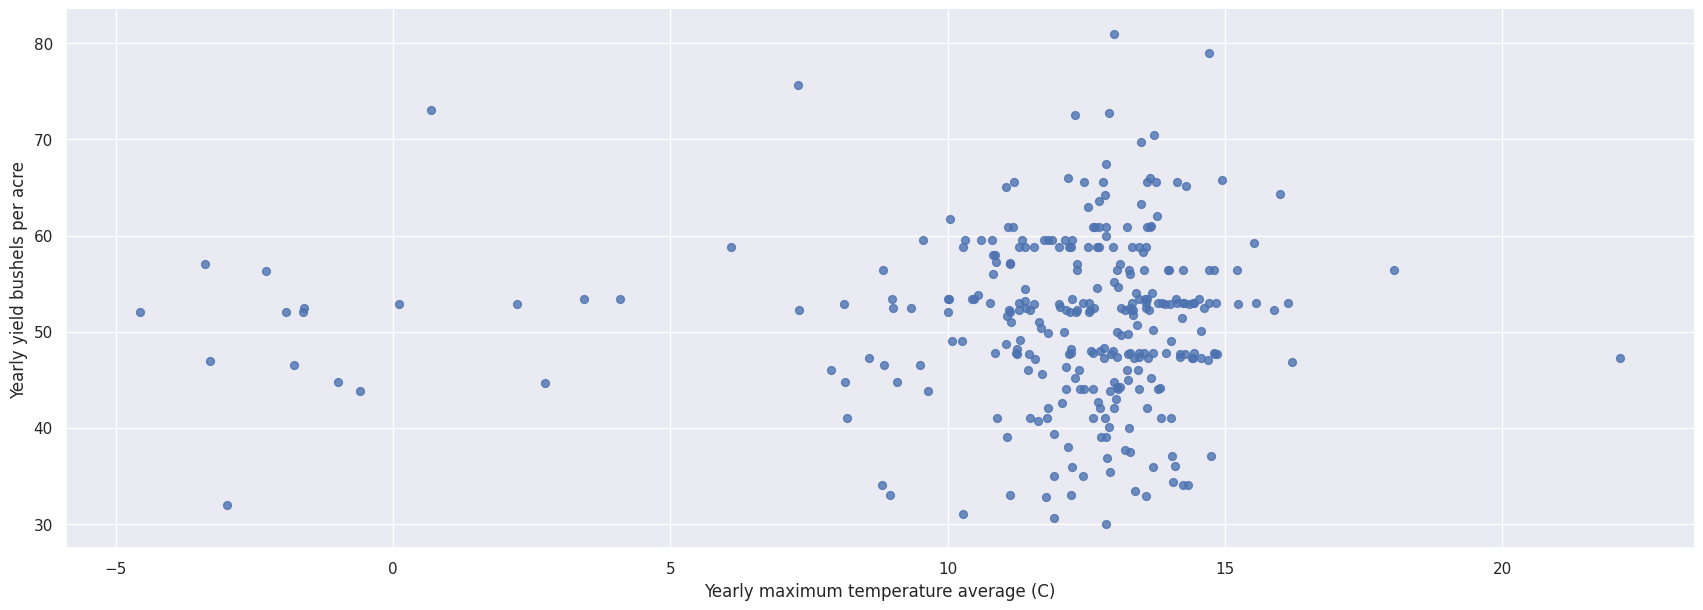

In [ ]:
from matplotlib import pyplot as plt
OneNFWeatherAndCropDataFrame.plot(kind='scatter', x='Yearly_max_temperature_average_c', y='Yearly_yield_bushels_per_acre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Yearly maximum temperature average (C)')
plt.ylabel('Yearly yield bushels per acre')
plt.locator_params(axis="both", integer=True, tight=True)

Periods during which temperature is negative should be removed since nothing grows under that condition!
Then we would probably have a loosee linear relationship between crop yield and temperature...


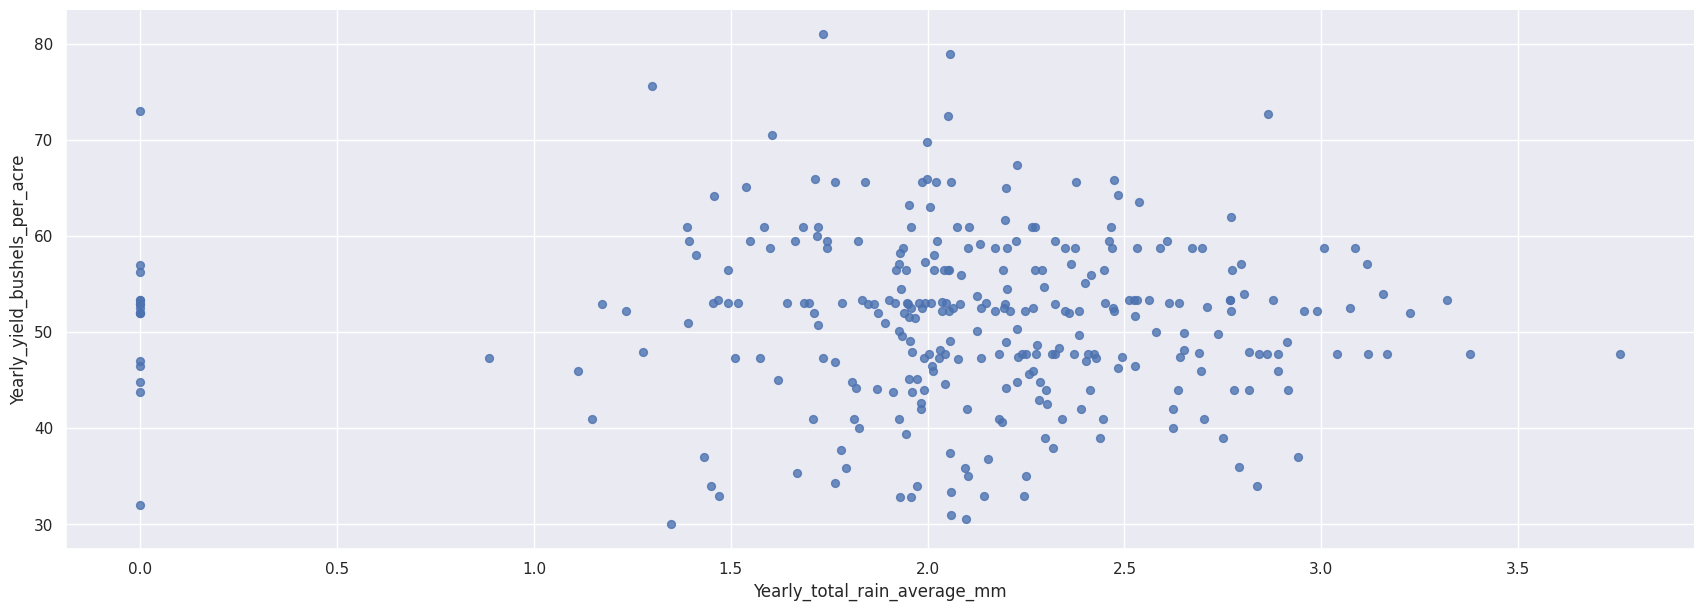

In [ ]:
from matplotlib import pyplot as plt
OneNFWeatherAndCropDataFrame.plot(kind='scatter', x='Yearly_total_rain_average_mm', y='Yearly_yield_bushels_per_acre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

The condition where there is crop yield when does not seem to be any precipitation probably illustrates a scenario where perhaps irrigation is heavily leveraged... those data points should be removed from the analysis...

### Final Analysis

#### Removing negative temperature from current analysis-bound data

In [ ]:
# Examining Correlation
OneNFWeatherAndCropDataFrame.corr(method='pearson')

<ipython-input-35-57881091eba3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  OneNFWeatherAndCropDataFrame.corr(method='pearson')


,Yearly_max_temperature_average_c,Yearly_total_rain_average_mm,Yearly_yield_bushels_per_acre
Yearly_max_temperature_average_c,1.000000,0.665556,0.019948
Yearly_total_rain_average_mm,0.665556,1.000000,-0.031880
Yearly_yield_bushels_per_acre,0.019948,-0.031880,1.000000


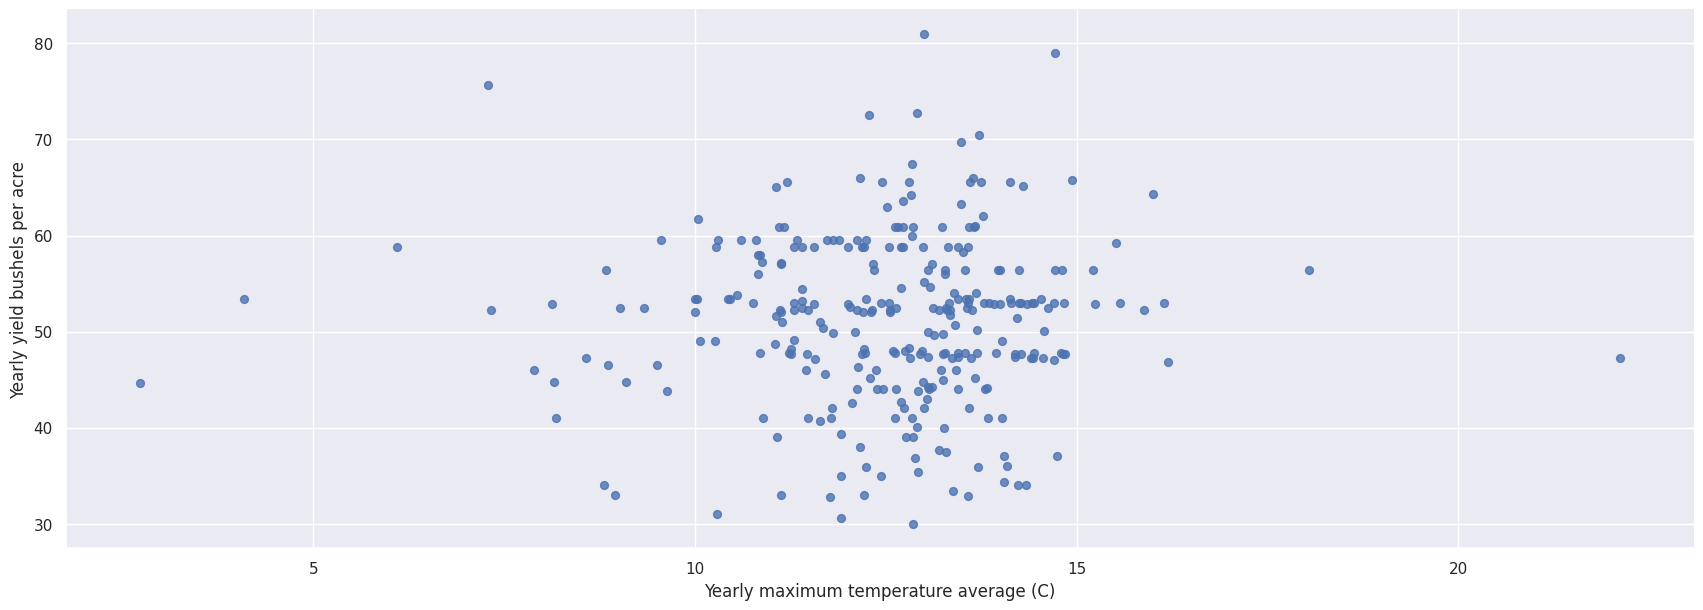

In [ ]:
NewOneNFWeatherAndCropDataFrame = pd.DataFrame()
NewOneNFWeatherAndCropDataFrame = OneNFWeatherAndCropDataFrame[~(OneNFWeatherAndCropDataFrame['Yearly_max_temperature_average_c'] <= 0)]
OneNFWeatherAndCropDataFrame = NewOneNFWeatherAndCropDataFrame.copy()
from matplotlib import pyplot as plt
OneNFWeatherAndCropDataFrame.plot(kind='scatter', x='Yearly_max_temperature_average_c', y='Yearly_yield_bushels_per_acre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Yearly maximum temperature average (C)')
plt.ylabel('Yearly yield bushels per acre')
plt.locator_params(axis="both", integer=True, tight=True)

#### Removing data indicating crop yield without any precipitation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1 to 339
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County                            288 non-null    object 
 1   Year                              288 non-null    object 
 2   Yearly_max_temperature_average_c  288 non-null    float64
 3   Yearly_total_rain_average_mm      288 non-null    float64
 4   Yearly_yield_bushels_per_acre     288 non-null    float64
dtypes: float64(3), object(2)
memory usage: 13.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1 to 339
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County                            288 non-null    object 
 1   Year                              288 non-null    object 
 2   Yearly_max_temperature_average_c  28

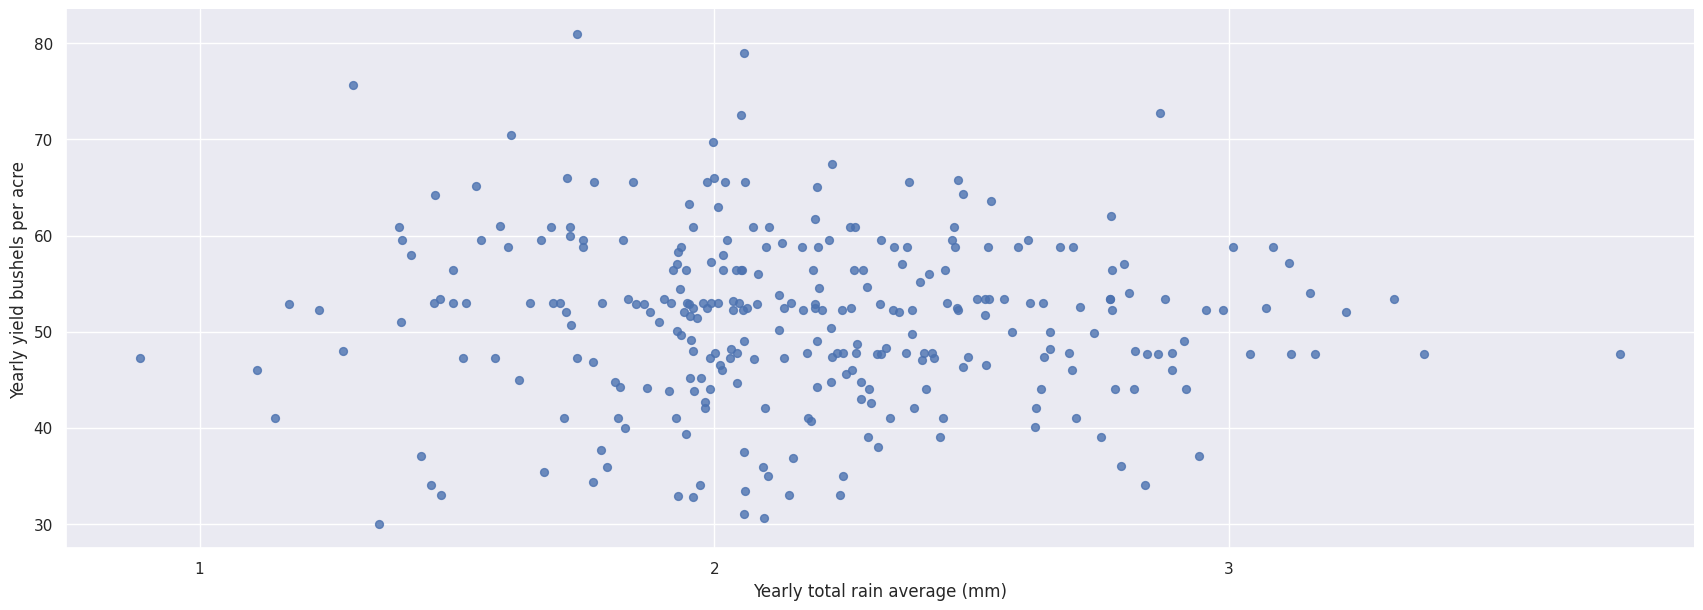

In [ ]:

from matplotlib import pyplot as plt
print(OneNFWeatherAndCropDataFrame.info())
NewOneNFWeatherAndCropDataFrame = pd.DataFrame()
NewOneNFWeatherAndCropDataFrame = OneNFWeatherAndCropDataFrame[~(OneNFWeatherAndCropDataFrame['Yearly_total_rain_average_mm'] <= 0.5)]
print(NewOneNFWeatherAndCropDataFrame.info())
OneNFWeatherAndCropDataFrame = NewOneNFWeatherAndCropDataFrame.copy()
from matplotlib import pyplot as plt
OneNFWeatherAndCropDataFrame.plot(kind='scatter', x='Yearly_total_rain_average_mm', y='Yearly_yield_bushels_per_acre', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Yearly total rain average (mm)')
plt.ylabel('Yearly yield bushels per acre')
plt.locator_params(axis="both", integer=True, tight=True)


#### Building a linear regression using 2004 and 2005 data to infer 2006 data

In [ ]:
independantVarData = pd.DataFrame(columns = ['Yearly_max_temperature_average_c','Yearly_total_rain_average_mm'])
#foo = OneNFWeatherAndCropDataFrame.loc[:,['Yearly_mean_temperature_average_c']]#['Yearly_mean_temperature_average_c'].copy()
independantVarData['Yearly_max_temperature_average_c'] = OneNFWeatherAndCropDataFrame[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2004) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2005)]['Yearly_max_temperature_average_c'].copy()
independantVarData['Yearly_total_rain_average_mm'] = OneNFWeatherAndCropDataFrame.loc[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2004) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2005)]['Yearly_total_rain_average_mm'].copy()
dependantVarData = OneNFWeatherAndCropDataFrame.loc[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2004) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2005)]['Yearly_yield_bushels_per_acre']
# Train the model (with sklearn)
regr = LinearRegression()
regr.fit(independantVarData, dependantVarData)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# Make a prediction
sampleIndependantVarData = pd.DataFrame(columns = ['Yearly_max_temperature_average_c','Yearly_total_rain_average_mm'])
#foo = OneNFWeatherAndCropDataFrame.loc[:,['Yearly_mean_temperature_average_c']]#['Yearly_mean_temperature_average_c'].copy()
sampleIndependantVarData['Yearly_max_temperature_average_c'] = OneNFWeatherAndCropDataFrame.loc[
                                                                  OneNFWeatherAndCropDataFrame['Year'] == 2006
                                                                  ]['Yearly_max_temperature_average_c'].copy()
sampleIndependantVarData['Yearly_total_rain_average_mm'] = OneNFWeatherAndCropDataFrame.loc[
                                                                  OneNFWeatherAndCropDataFrame['Year'] == 2006
                                                                  ]['Yearly_total_rain_average_mm'].copy()

samplePredictedDependantVarData = regr.predict(sampleIndependantVarData)
sampleActualDependantVarData = OneNFWeatherAndCropDataFrame.loc[
                                OneNFWeatherAndCropDataFrame['Year'] == 2006
                                ]['Yearly_yield_bushels_per_acre']



Intercept: 
 45.92013991664757
Coefficients: 
 [-1.89522475  9.0727384 ]


Exploring Standard Statistics

#### Studying predicted vs actual data - 2004,2005 & 2006

In [ ]:
from sklearn.metrics import mean_squared_error
# Predicted (2006) yield data
print("Predicted 2006 data: ",list(samplePredictedDependantVarData))

# Actual 2006 yield data
print("Actual 2006 data: ",list(sampleActualDependantVarData))


#mse = mean_squared_error(sampleActualDependantVarData, samplePredictedDependantVarData)
#print("Mean Square Error - w/ 2006 predicted and actual data", mse)
rmse = mean_squared_error(sampleActualDependantVarData, samplePredictedDependantVarData, squared = False)
print("\nMean Square Error - w/ 2006 predicted and actual data", rmse)
print("\nNote:")
print("Excellent when RRMSE < 10%")
print("Good when RRMSE is between 10% and 20%")
print("Fair when RRMSE is between 20% and 30%")
print("Poor when RRMSE > 30%")

Predicted 2006 data:  [45.9761270142355, 44.49958092060224, 45.42474020881125, 46.38504669771153, 45.45383042908195, 41.82365658446524, 45.98372054099437, 46.370649903347754, 46.68371838020601, 46.2269754354098, 44.95526126772886, 44.5273416138113, 46.670010668037875, 46.29100649042135, 49.1792885425555, 41.421710240743835, 45.764215492766, 45.08252539289049]
Actual 2006 data:  [44.0, 34.0, 54.0, 50.0, 46.27804227103914, 42.0, 37.0, 44.0, 46.0, 44.0, 62.0, 36.0, 39.0, 53.0, 54.0, 46.0, 49.0, 42.0]

Mean Square Error - w/ 2006 predicted and actual data 6.767833909612419

Note:
Excellent when RRMSE < 10%
Good when RRMSE is between 10% and 20%
Fair when RRMSE is between 20% and 30%
Poor when RRMSE > 30%


#### Building a linear regression using 2007 and 2008 dat to infer 2009 data

In [ ]:
independantVarData = pd.DataFrame(columns = ['Yearly_max_temperature_average_c','Yearly_total_rain_average_mm'])
#foo = OneNFWeatherAndCropDataFrame.loc[:,['Yearly_mean_temperature_average_c']]#['Yearly_mean_temperature_average_c'].copy()
independantVarData['Yearly_max_temperature_average_c'] = OneNFWeatherAndCropDataFrame[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2007) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2008)]['Yearly_max_temperature_average_c'].copy()
independantVarData['Yearly_total_rain_average_mm'] = OneNFWeatherAndCropDataFrame.loc[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2007) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2008)]['Yearly_total_rain_average_mm'].copy()
dependantVarData = OneNFWeatherAndCropDataFrame.loc[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2007) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2008)]['Yearly_yield_bushels_per_acre']
# Train the model (with sklearn)
regr = LinearRegression()
regr.fit(independantVarData, dependantVarData)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# Make a prediction
sampleIndependantVarData = pd.DataFrame(columns = ['Yearly_max_temperature_average_c','Yearly_total_rain_average_mm'])
#foo = OneNFWeatherAndCropDataFrame.loc[:,['Yearly_mean_temperature_average_c']]#['Yearly_mean_temperature_average_c'].copy()
sampleIndependantVarData['Yearly_max_temperature_average_c'] = OneNFWeatherAndCropDataFrame.loc[
                                                                  OneNFWeatherAndCropDataFrame['Year'] == 2009
                                                                  ]['Yearly_max_temperature_average_c'].copy()
sampleIndependantVarData['Yearly_total_rain_average_mm'] = OneNFWeatherAndCropDataFrame.loc[
                                                                  OneNFWeatherAndCropDataFrame['Year'] == 2009
                                                                  ]['Yearly_total_rain_average_mm'].copy()

samplePredictedDependantVarData = regr.predict(sampleIndependantVarData)
sampleActualDependantVarData = OneNFWeatherAndCropDataFrame.loc[
                                OneNFWeatherAndCropDataFrame['Year'] == 2009
                                ]['Yearly_yield_bushels_per_acre']
# Prepare a confusion matrix
#confusion_matrix = confusion_matrix(sampleActualDependantVarData, samplePredictedDependantVarData)


Intercept: 
 48.688605089732334
Coefficients: 
 [-0.70468644  1.11104789]


Studying predicted vs actual data - 2007,2008 & 2009

In [ ]:
# Predicted (2009) yield data
print("Predicted 2009 data: ",list(samplePredictedDependantVarData))
# Actual 2006 yield data
print("Actual 2009 data: ",list(sampleActualDependantVarData))

#mse = mean_squared_error(sampleActualDependantVarData, samplePredictedDependantVarData)
#print("Mean Square Error - w/ 2009 predicted and actual data", mse)
rmse = mean_squared_error(sampleActualDependantVarData, samplePredictedDependantVarData, squared = False)
print("\nMean Square Error - w/ 2009 predicted and actual data", rmse)
print("\nNote:")
print("Excellent when RRMSE < 10%")
print("Good when RRMSE is between 10% and 20%")
print("Fair when RRMSE is between 20% and 30%")
print("Poor when RRMSE > 30%")

Predicted 2009 data:  [42.69130576722059, 42.01398120147501, 43.101324990399874, 44.009108538678944, 44.796105388940845, 41.81281965007769, 43.59362047795574, 42.85678881170462, 43.463715324918915, 42.831893110323925, 42.1689848544434, 42.944443266395105, 43.72857626214024, 44.03456019146116, 42.468013346276265, 43.3025428064432, 44.68154001142591, 43.37783740643046, 42.574288904097315]
Actual 2009 data:  [38.0, 56.0, 41.0, 53.0, 46.51890443441254, 41.0, 39.0, 46.0, 52.0, 44.0, 52.0, 48.0, 31.0, 49.0, 44.0, 58.0, 46.51890443441254, 56.0, 42.0]

Mean Square Error - w/ 2009 predicted and actual data 7.615696842655504

Note:
Excellent when RRMSE < 10%
Good when RRMSE is between 10% and 20%
Fair when RRMSE is between 20% and 30%
Poor when RRMSE > 30%


In [ ]:
OneNFWeatherAndCropDataFrame[(
                                      OneNFWeatherAndCropDataFrame['Year'] == 2007) |
                                      (OneNFWeatherAndCropDataFrame['Year'] == 2008)]['County'].unique()

array(['Durham', 'Elgin', 'Frontenac', 'Grey', 'Haliburton', 'Halton',
       'Hastings', 'Lanark', 'Leeds and Grenville',
       'Lennox and Addington', 'Middlesex', 'Northumberland', 'Ottawa',
       'Oxford', 'Simcoe', 'Sudbury', 'Wellington', 'York', 'Niagara'],
      dtype=object)

In [ ]:
for lYear in range(2004,2023):
  print(lYear,
OneNFWeatherAndCropDataFrame[(OneNFWeatherAndCropDataFrame['Year'] == lYear)]['Yearly_max_temperature_average_c'].mean())

2004 11.342162870849068
2005 12.919081959145233
2006 13.352783593530889
2007 11.92033370238913
2008 11.605709212845726
2009 11.465279552804615
2010 13.228584739008614
2011 11.887279997292424
2012 13.873290356292133
2013 11.802182045262667
2014 11.2395801005354
2015 12.547252400414694
2016 14.076119202179969
2017 13.330914177246433
2018 12.298368579374475
2019 11.76717181075509
2020 12.882049608220553
2021 13.781506989125203
2022 12.601378808266738


## Conclusion

There were too many periods with scarce crop data. It has impacted this study's ability to perhaps have more folds to evaluate the effectiveness of linear regression (or any other methodology) to help predict the relationship between wheat crop yield and temperature and/or precipitation.
We are  not in a position to validate the conclusions that were reached in  the papers which were examined as part of the literature review
There are however  signs of correlation and linearity between temperature and precipitation  with crop yield.
